In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from agae import *
from utils import *

In [3]:

device = get_default_device()
print(torch.__version__)  #注意是双下划线
print(device)

1.13.1+cu117
cuda


### 处理正常数据

In [4]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal.csv", header=0)#, nrows=1000)
print(normal.head())
print(normal.columns)

                Timestamp  FIT101    LIT101  MV101  P101  P102    AIT201  \
0   22/12/2015 4:30:00 PM     0.0  124.3135      1     1     1  251.9226   
1   22/12/2015 4:30:01 PM     0.0  124.3920      1     1     1  251.9226   
2   22/12/2015 4:30:02 PM     0.0  124.4705      1     1     1  251.9226   
3   22/12/2015 4:30:03 PM     0.0  124.6668      1     1     1  251.9226   
4   22/12/2015 4:30:04 PM     0.0  124.5098      1     1     1  251.9226   

     AIT202    AIT203  FIT201  ...  P501  P502    PIT501  PIT502  PIT503  \
0  8.313446  312.7916     0.0  ...     1     1  9.100231     0.0  3.3485   
1  8.313446  312.7916     0.0  ...     1     1  9.100231     0.0  3.3485   
2  8.313446  312.7916     0.0  ...     1     1  9.100231     0.0  3.3485   
3  8.313446  312.7916     0.0  ...     1     1  9.100231     0.0  3.3485   
4  8.313446  312.7916     0.0  ...     1     1  9.100231     0.0  3.3485   

     FIT601  P601  P602  P603  Normal/Attack  
0  0.000256     1     1     1         N

In [5]:
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape
print(normal.head())

   FIT101    LIT101  MV101  P101  P102    AIT201    AIT202    AIT203  FIT201  \
0     0.0  124.3135      1     1     1  251.9226  8.313446  312.7916     0.0   
1     0.0  124.3920      1     1     1  251.9226  8.313446  312.7916     0.0   
2     0.0  124.4705      1     1     1  251.9226  8.313446  312.7916     0.0   
3     0.0  124.6668      1     1     1  251.9226  8.313446  312.7916     0.0   
4     0.0  124.5098      1     1     1  251.9226  8.313446  312.7916     0.0   

   MV201  ...  FIT504  P501  P502    PIT501  PIT502  PIT503    FIT601  P601  \
0      1  ...     0.0     1     1  9.100231     0.0  3.3485  0.000256     1   
1      1  ...     0.0     1     1  9.100231     0.0  3.3485  0.000256     1   
2      1  ...     0.0     1     1  9.100231     0.0  3.3485  0.000256     1   
3      1  ...     0.0     1     1  9.100231     0.0  3.3485  0.000256     1   
4      1  ...     0.0     1     1  9.100231     0.0  3.3485  0.000256     1   

   P602  P603  
0     1     1  
1     1     

In [6]:
# Transform all columns into float64
normal = normal.astype(float)

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [8]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### 处理攻击数据

In [9]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack.csv",header=0)#, nrows=1000)
print(normal.columns)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values] #等于normal就是0，异常就是1
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
print("测试数据集形状：{}，标签长度：{}".format(attack.shape, len(labels)))

RangeIndex(start=0, stop=51, step=1)
测试数据集形状：(449919, 51)，标签长度：449919


In [10]:
# Transform all columns into float64
attack = attack.astype(float)
x = attack.values
x_scaled = min_max_scaler.fit_transform(x)
attack = pd.DataFrame(x_scaled)

In [11]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.879322,0.452962,1.0,1.0,0.0,0.942783,0.876785,0.436773,0.865044,1.0,...,0.987464,1.0,0.0,0.985802,0.837398,0.987359,0.000071,0.0,0.0,0.0
1,0.886285,0.453015,1.0,1.0,0.0,0.942783,0.876785,0.436773,0.865044,1.0,...,0.987464,1.0,0.0,0.985802,0.837398,0.987783,0.000071,0.0,0.0,0.0


In [12]:
print(normal.shape)
window_size = 12
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]] #窗口化处理
windows_normal.shape

(495000, 51)


(494988, 12, 51)

In [25]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

In [26]:
## Training

In [53]:
import torch.utils.data as data_utils

BATCH_SIZE =  9000
N_EPOCHS = 50
hidden_size = 200

In [54]:
w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=hidden_size
windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]
print("输入层维度：{}， 潜空间维度：{}，训练数据集：{}，验证数据集：{}".format(w_size, z_size, windows_normal_train.shape, windows_normal_val.shape))

输入层维度：612， 潜空间维度：200，训练数据集：(395990, 12, 51)，验证数据集：(98998, 12, 51)


In [55]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
model = AGAEModel(w_size, z_size)
model = to_device(model,device)

In [56]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], 训练耗时：4.12s, val_loss1: 0.0286, val_loss2: 0.0278
Epoch [1], 训练耗时：3.80s, val_loss1: 0.0296, val_loss2: -0.0031
Epoch [2], 训练耗时：4.20s, val_loss1: 0.0301, val_loss2: -0.0123
Epoch [3], 训练耗时：3.73s, val_loss1: 0.0300, val_loss2: -0.0169
Epoch [4], 训练耗时：4.36s, val_loss1: 0.0300, val_loss2: -0.0195
Epoch [5], 训练耗时：4.14s, val_loss1: 0.0301, val_loss2: -0.0213
Epoch [6], 训练耗时：4.48s, val_loss1: 0.0306, val_loss2: -0.0229
Epoch [7], 训练耗时：4.24s, val_loss1: 0.0308, val_loss2: -0.0242
Epoch [8], 训练耗时：4.25s, val_loss1: 0.0307, val_loss2: -0.0248
Epoch [9], 训练耗时：3.90s, val_loss1: 0.0313, val_loss2: -0.0259
Epoch [10], 训练耗时：3.81s, val_loss1: 0.0304, val_loss2: -0.0256
Epoch [11], 训练耗时：4.05s, val_loss1: 0.0307, val_loss2: -0.0262
Epoch [12], 训练耗时：4.11s, val_loss1: 0.0318, val_loss2: -0.0275
Epoch [13], 训练耗时：4.19s, val_loss1: 0.0309, val_loss2: -0.0270
Epoch [14], 训练耗时：3.95s, val_loss1: 0.0322, val_loss2: -0.0285
Epoch [15], 训练耗时：3.82s, val_loss1: 0.0305, val_loss2: -0.0271
Epoch [16], 训练耗时：3.

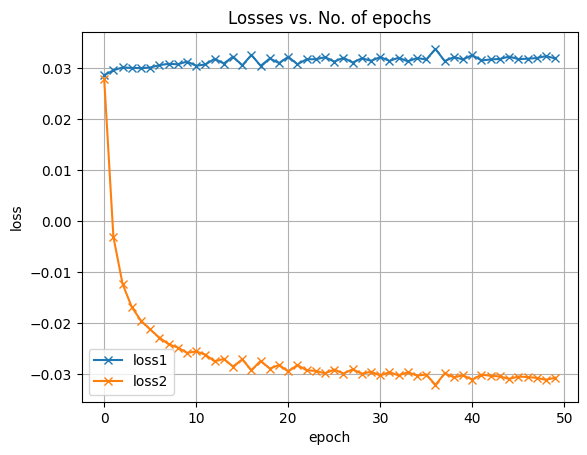

In [58]:
plot_history(history)

In [59]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [60]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [61]:
#测试集测试，并展开成数组
results=testing(model,test_loader)
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
print(y_pred)

[0.01954766 0.01966042 0.01972556 ... 0.00236442 0.00234378 0.00222256]


In [62]:
#标签窗口化
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))
#以窗口为单位设置异常
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
print(len(y_test))

449907


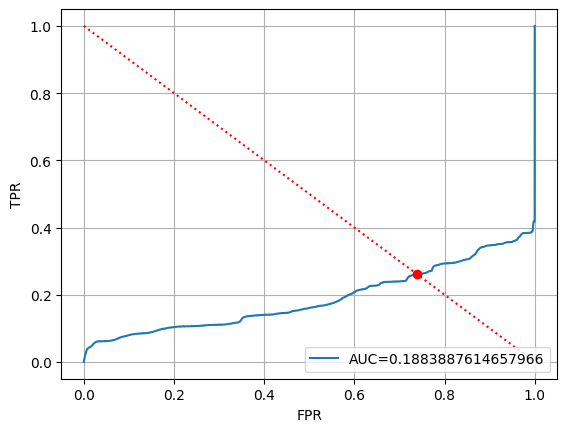

In [63]:
threshold=ROC(y_test,y_pred)